# Landscape Image Prediction

### Import Libraries

In [12]:
import numpy as np
import tensorflow as tf
import pathlib
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt


### Download Train and Validation Set

In [13]:
# Download training data
train_url = 'https://zenodo.org/record/5512793/files/train.tgz'
train_dir = tf.keras.utils.get_file(origin=train_url, fname='train', untar=True)
train_dir = pathlib.Path(train_dir)

# Download validation data
valid_url = 'https://zenodo.org/record/5512793/files/valid.tgz'
valid_dir = tf.keras.utils.get_file(origin=valid_url, fname='valid', untar=True)
valid_dir = pathlib.Path(valid_dir)

# Print number of training and validation images
train_image_count = len(list(train_dir.glob('*/*.jpg')))
valid_image_count = len(list(valid_dir.glob('*/*.jpg')))
print(train_image_count, valid_image_count)


14034 3000


### Package into Tensorflow Objects

In [14]:
train_data = tf.keras.preprocessing.image_dataset_from_directory(train_dir,
                                                                 image_size=(150,150),
                                                                 batch_size=32)
valid_data = tf.keras.preprocessing.image_dataset_from_directory(valid_dir,
                                                                 image_size=(150,150),
                                                                 batch_size=32)
print(train_data, valid_data)


Found 14034 files belonging to 6 classes.
Found 3000 files belonging to 6 classes.
<_BatchDataset element_spec=(TensorSpec(shape=(None, 150, 150, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))> <_BatchDataset element_spec=(TensorSpec(shape=(None, 150, 150, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>


### Sample Images of Dataset

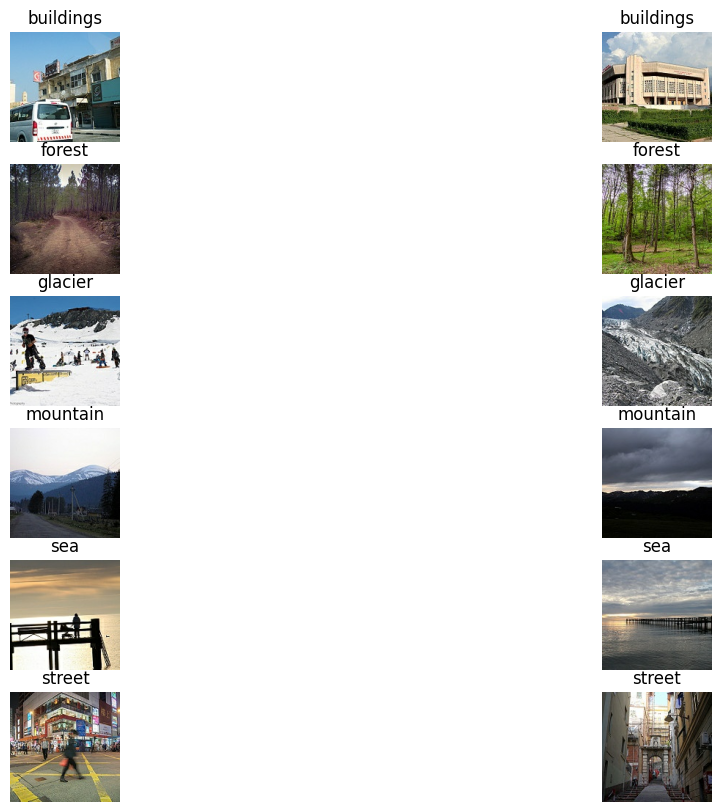

In [15]:
def display_two_samples_of_each_class(dataset, class_names):
    """
    Display two samples of each class from a given dataset.
    
    Parameters:
    - dataset: The TensorFlow dataset to sample from.
    - class_names: List of class names.
    """
    class_images = {class_name: [] for class_name in class_names}
    
    for images, labels in dataset:
        for img, lbl in zip(images, labels):
            class_label = class_names[lbl]
            if len(class_images[class_label]) < 2:
                class_images[class_label].append(img)
    
        if all(len(images) == 2 for images in class_images.values()):
            break
            
    plt.figure(figsize=(14, 10))
    for idx, class_name in enumerate(class_names):
        for j, img in enumerate(class_images[class_name]):
            ax = plt.subplot(len(class_names), 2, idx * 2 + j + 1)
            plt.imshow(img.numpy().astype("uint8"))
            plt.title(class_name)
            plt.axis("off")

# Call the function to display images
display_two_samples_of_each_class(train_data, train_data.class_names)


### Build, compile, and train the model

In [18]:
# Download pre-trained convolution network
base_model = tf.keras.applications.MobileNetV2(input_shape=(150,150,3),
                                               include_top=False,
                                               weights='imagenet')
base_model.trainable = False  # Turn off training for the base model

# build complete inference model
model = tf.keras.Sequential()
model.add(tf.keras.layers.experimental.preprocessing.Rescaling(1.0/255, input_shape=[150,150,3]))
model.add(tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal'))
model.add(tf.keras.layers.experimental.preprocessing.RandomRotation(0.2))
model.add(base_model)
model.add(tf.keras.layers.MaxPool2D())
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(units=6, activation=tf.keras.activations.softmax))

model.summary()

# compile model
model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

# fit model
model.fit(train_data, epochs=20, validation_data=valid_data)


Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_4 (Rescaling)     (None, 150, 150, 3)       0         
                                                                 
 random_flip_4 (RandomFlip)  (None, 150, 150, 3)       0         
                                                                 
 random_rotation_4 (RandomR  (None, 150, 150, 3)       0         
 otation)                                                        
                                                                 
 mobilenetv2_1.00_224 (Func  (None, 5, 5, 1280)        2257984   
 tional)                                                         
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 2, 2, 1280)        0         
 g2D)                                                            
                                                      

Epoch 1/20
439/439 [==============================] - 56s 125ms/step - loss: 0.9474 - accuracy: 0.7812 - val_loss: 0.9370 - val_accuracy: 0.8037
Epoch 2/20
439/439 [==============================] - 55s 125ms/step - loss: 0.8609 - accuracy: 0.8234 - val_loss: 1.0433 - val_accuracy: 0.8070
Epoch 3/20
439/439 [==============================] - 55s 126ms/step - loss: 0.8008 - accuracy: 0.8381 - val_loss: 0.6776 - val_accuracy: 0.8620
Epoch 4/20
439/439 [==============================] - 56s 126ms/step - loss: 0.8281 - accuracy: 0.8437 - val_loss: 0.9575 - val_accuracy: 0.8277
Epoch 5/20
439/439 [==============================] - 54s 123ms/step - loss: 0.8306 - accuracy: 0.8452 - val_loss: 0.7290 - val_accuracy: 0.8700
Epoch 6/20
439/439 [==============================] - 55s 125ms/step - loss: 0.8200 - accuracy: 0.8479 - val_loss: 0.7581 - val_accuracy: 0.8537
Epoch 7/20
439/439 [==============================] - 54s 124ms/step - loss: 0.7693 - accuracy: 0.8533 - val_loss: 1.0286 - val_ac

### Evaluate the model using a confusion matrix

94/94 [==============================] - 10s 99ms/step


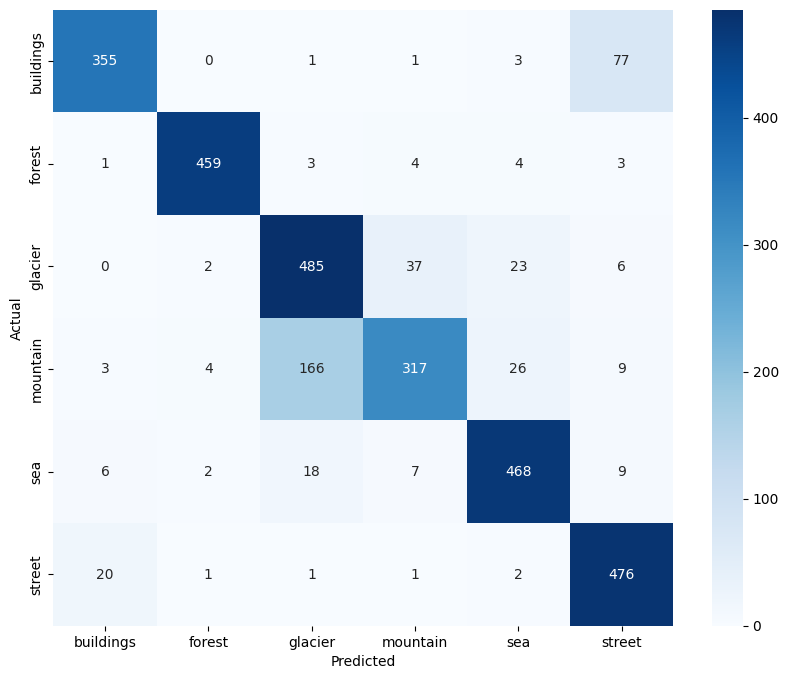

In [17]:
# Predict classes for the validation dataset
valid_images, valid_labels = next(iter(valid_data.unbatch().batch(valid_image_count)))
predictions = model.predict(valid_images)
predicted_labels = np.argmax(predictions, axis=1)

# Compute the confusion matrix
cm = confusion_matrix(valid_labels.numpy(), predicted_labels)

# Get class names
class_names = valid_data.class_names

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()
